### Notebook for noodling with screenshot reading algorithm.

Output should consist of a dataframe that has text, placement, prominence, maybe color?

In [12]:
# Import the usual suspects.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import ipdb
import pickle
import string
import sys
import time
import math
import csv
import re
import cv2

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

Grab test image.

In [13]:
file = 'data/testDir/Juniper Networks Screenshots - F5 Test - Nov 1, 2020 21_48_13.jpeg'
img = cv2.imread(file)
height, width, channels = img.shape

In [14]:
output = pytesseract.image_to_data(image = Image.open(file), output_type = pytesseract.Output.DATAFRAME)

In [15]:
output

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,1920,1080,-1,NaN
1,2,1,1,0,0,0,1270,9,293,17,-1,NaN
2,3,1,1,1,0,0,1270,9,293,17,-1,NaN
3,4,1,1,1,1,0,1270,9,293,17,-1,NaN
4,5,1,1,1,1,1,1270,9,16,16,91,@
...,...,...,...,...,...,...,...,...,...,...,...,...
159,5,1,10,1,1,3,583,1040,121,16,0,aL
160,2,1,11,0,0,0,0,914,1872,166,-1,NaN
161,3,1,11,1,0,0,0,914,1872,166,-1,NaN
162,4,1,11,1,1,0,0,914,1872,166,-1,NaN


Output now contains the full output of tesseract. Columns are as follows:

* **level**: hierarchical layout (a word is in a line, which is in a paragraph, which is in a block, which is in a page), a value from 1 to 5
    * 1: page
    * 2: block
    * 3: paragraph
    * 4: line
    * 5: word
* **page_num**: when provided with a list of images, indicates the number of the file, when provided with a multi-pages document, indicates the page number, starting from 1
* **block_num**: block number within the page, starting from 0
* **par_num**: paragraph number within the block, starting from 0
* **line_num**: line number within the paragraph, starting from 0
* **word_num**: word number within the line, starting from 0
* **left**: x coordinate in pixels of the text bounding box top left corner, starting from the left of the image
* **top**: y coordinate in pixels of the text bounding box top left corner, starting from the top of the image
* **width**: width of the text bounding box in pixels
* **height**: height of the text bounding box in pixels
* **conf**: confidence value, from 0 (no confidence) to 100 (maximum confidence), -1 for all level except 5
* **text**: detected text, empty for all levels except 5

Only retaining words with confidence greater than 50 seems to be a good way to get rid of nonsense, but this might be worth looking into.

Grouping terms by block number is likely the best way to get an idea for the sizes of entire chunks of text.

In [16]:
goodWords = output[output['conf'] > 50]
badWords = output[(output['conf'] <= 50) & (output['conf'] > 0)]

We should export the good words dataframe, but I also want to generate a summary dataframe that contains sizes and complete sentences for all blocks.

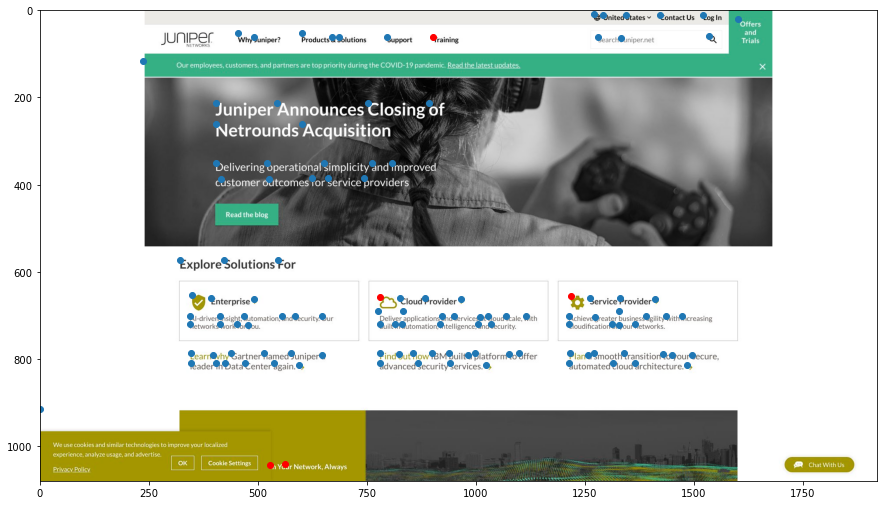

In [17]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.imshow(img)
plt.scatter(x=goodWords['left'],y=goodWords['top'])
plt.scatter(x=badWords['left'],y=badWords['top'],color='r')
plt.show()

In [18]:
# A for loop that will go through each block in the good words list and output the sentence, mean confidence, and size. Maybe average position too?
# Populate a dataframe with this info.

outDat = []
for block in np.unique(goodWords['block_num']) : 
    chunk = goodWords[goodWords['block_num'] == block]
    sentence = chunk['text'].str.cat(sep = " ") # concatenate into a single sentence
    if np.unique(sentence) == ' ' : # skip empty text
        continue    
    meanConf = np.mean(chunk['conf']) # mean confidence score
    size = 100*((max(chunk['left']) - min(chunk['left'])) * (max(chunk['top']) - min(chunk['top']))/(height*width))  
        # compute size as a percentage of image total
    outDat.append([sentence,size/len(sentence),meanConf,size])
    
blockInfo = pd.DataFrame(outDat, columns = ["sentence","sizeWtChar","meanConf","sizePct"])

In [19]:
blockInfo.sort_values('sizeWtChar',ascending=False,axis=0)

,sentence,sizeWtChar,meanConf,sizePct
3,Juniper Announces Closing of Netrounds Acquisition,0.022685,94.666667,1.134259
6,"@ Enterprise > Cloud Provider > Service Provider > Al-driven insight, automation, and security. Our Deliver applications and services at cloud scale, with Achieve greater business agility with increasing networks work for you. built in automation, intelligence, and security. cloudification of your networks. Learn why Gartner named Juniper a Find out how IBM built a platform to offer Plan a smooth transition to your secure, leader in Data Center again. > advanced security services. > automated cloud architecture. >",0.017234,93.848101,8.944444
4,"Delivering operational simplicity and improved, ustomer outcomes for service providers",0.008135,90.400000,0.699653
1,Why Juniper? Products & Solutions Support,0.004034,91.833333,0.165413
2,Search Juniper.net Q,0.002450,90.000000,0.048997
0,@ United States» ContactUs Login,0.000760,85.200000,0.024306
5,Explore Solutions For,0.000517,96.000000,0.010851
7,,0.000000,95.000000,0.000000


In [20]:
# Wrap in a function to do it for all images in a directory and output all phrases in descending order of size.

def readWebsites(dir = '/Users/mehmetalpaslan/BlueOcean/screenshot-reader/data/testDir/') :

    types = ("*.jpg", "*.png", "*.jpeg")
    ad_images = []
    for files in types:
        ad_images.extend(
            glob.glob(dir + files)
        )
    # Set up empty list to collect results.
    
    out = []
    
    # Run tesseract on all images and collate results.
    
    for file in ad_images :
        
        # Grab image dimensions.
        img = cv2.imread(file)
        height, width, channels = img.shape

        output = pytesseract.image_to_data(image = Image.open(file), output_type = pytesseract.Output.DATAFRAME)
        filename = file.split('/')[-1]
        
        # Find good words and bad words based on confidence.
        
        goodWords = output[output['conf'] > 50]
        badWords = output[(output['conf'] <= 50) & (output['conf'] > 0)]
        
        # Organize block information for this image and append to full output.

        for block in np.unique(goodWords['block_num']) : 
            chunk = goodWords[goodWords['block_num'] == block]
            sentence = chunk['text'].str.cat(sep = " ") # concatenate into a single sentence
            if np.unique(sentence) == ' ' : # skip empty text
                continue    
            meanConf = np.mean(chunk['conf']) # mean confidence score
            size = 100*((max(chunk['left']) - min(chunk['left'])) * (max(chunk['top']) - min(chunk['top']))/(height*width))  
            # compute size as a percentage of image total
            out.append([filename,sentence,meanConf,size,size/len(sentence)]) # also grab size / num of chars. this seems to be a good way to find topics.
        
    # Create dataframe.
    blockInfo = pd.DataFrame(out, columns = ["filename","sentence","meanConf","sizePct","sizeWtChar"])
    
    # Sort and output. Also remove duplicates.
    blockInfo = blockInfo.sort_values(['sizeWtChar','meanConf'],ascending=[False,True])
    return(blockInfo)

In [21]:
dir_test = readWebsites()

In [22]:
pd.set_option('display.max_colwidth', None)
dir_test.head(10)

,filename,sentence,meanConf,sizePct,sizeWtChar
47,"Juniper Networks Screenshots - F5 Test - Nov 1, 2020 21_48_13.jpeg",Juniper Announces Closing of Netrounds Acquisition,94.666667,1.134259,0.022685
30,"Juniper Networks Screenshots - Juniper Networks - Mar 4, 2021 15_54_12.jpeg",Experience the Al-Driven Enterprise,94.000000,0.631944,0.018056
50,"Juniper Networks Screenshots - F5 Test - Nov 1, 2020 21_48_13.jpeg","@ Enterprise > Cloud Provider > Service Provider > Al-driven insight, automation, and security. Our Deliver applications and services at cloud scale, with Achieve greater business agility with increasing networks work for you. built in automation, intelligence, and security. cloudification of your networks. Learn why Gartner named Juniper a Find out how IBM built a platform to offer Plan a smooth transition to your secure, leader in Data Center again. > advanced security services. > automated cloud architecture. >",93.848101,8.944444,0.017234
20,"Juniper Networks Screenshots - F5 - Aug 4, 2020 14_59_22.jpeg","Al-driven insight, automation, and security. Our Deliver applications and services at cloud scale, with networks work for you. built in automation, intelligence, and security. Learn why Gartner named Juniper a Find out how IBM built a platform to offer leader in Data Center again. > advanced security services. >",94.408163,4.567419,0.014592
15,"Juniper Networks Screenshots - F5 - Aug 4, 2020 14_59_22.jpeg","Superior User Experiences, from Client to Cloud",96.000000,0.632089,0.013449
16,"Juniper Networks Screenshots - F5 - Aug 4, 2020 14_59_22.jpeg","Now, the Al-driven enterprise brings your WLAN, and WAN together. \",93.454545,0.847319,0.012647
31,"Juniper Networks Screenshots - Juniper Networks - Mar 4, 2021 15_54_12.jpeg",Make your network simple to run and easy to use with Session Smart technology and superior,95.625000,0.833816,0.009265
35,"Juniper Networks Screenshots - Juniper Networks - Mar 4, 2021 15_54_12.jpeg",the network for the next decade. Experts are taking notice. >,95.454545,0.500096,0.008198
48,"Juniper Networks Screenshots - F5 Test - Nov 1, 2020 21_48_13.jpeg","Delivering operational simplicity and improved, ustomer outcomes for service providers",90.400000,0.699653,0.008135
19,"Juniper Networks Screenshots - F5 - Aug 4, 2020 14_59_22.jpeg",g Enterprise > a Cloud Provider >,89.571429,0.267361,0.008102
